MEmodelkan Data HARIAN LSTM

In [1]:
from datetime import date
from pandas_datareader import data
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import numpy as np
import math
from sklearn.metrics import mean_squared_error, mean_absolute_error
import yfinance as yf


In [2]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)


In [486]:
#Saham yang akan dimodelkan
#,"ASII.JK","ICBP.JK","JSMR.JK"
tickers = ["ICBP.JK"]
#range dari tanggal yang dibutuhkan
today = date.today()
# print(today)
start_date = '2010-01-01'
end_date = '2022-03-22'
# end_date = today

#ambil data
panel_data = data.DataReader(tickers, 'yahoo',start_date, end_date)
panel_data



Attributes,Adj Close,Close,High,Low,Open,Volume
Symbols,ICBP.JK,ICBP.JK,ICBP.JK,ICBP.JK,ICBP.JK,ICBP.JK
Date,,,,,,
2010-01-04,1443.428345,1837.5,1850.0,1762.5,1787.5,26442000.0
2010-01-05,1472.886230,1875.0,1887.5,1825.0,1875.0,42874000.0
2010-01-06,1463.067139,1862.5,1925.0,1862.5,1900.0,44946000.0
2010-01-07,1472.886230,1875.0,1912.5,1862.5,1875.0,24863000.0
2010-01-08,1482.705444,1887.5,1912.5,1862.5,1900.0,19118000.0
...,...,...,...,...,...,...
2022-03-16,7625.000000,7625.0,7650.0,7425.0,7425.0,7742600.0
2022-03-17,7575.000000,7575.0,7700.0,7475.0,7650.0,6832200.0


In [487]:
# #OFFLINE TESTING
# start_date = '2010-01-04'
# end_date = '2021-10-26'

In [488]:
# panel_data = []
# panel_data = pd.read_csv('E:\programming\lstm\ANTM.JK.csv')
# panel_data.set_index("Date", inplace = True)
# panel_data

In [489]:
close = panel_data["Close"]

all_weekdays = pd.date_range(start = start_date, end=end_date, freq='D')

close = close.reindex(all_weekdays)

close = close.dropna()
close

#print(all_weekdays)

Symbols,ICBP.JK
2010-01-04,1837.5
2010-01-05,1875.0
2010-01-06,1862.5
2010-01-07,1875.0
2010-01-08,1887.5
...,...
2022-03-16,7625.0
2022-03-17,7575.0
2022-03-18,7575.0
2022-03-21,7450.0


In [490]:
dataframe = close
dataset = dataframe.values
dataset = dataset.astype('float32')
dataset

array([[1837.5],
       [1875. ],
       [1862.5],
       ...,
       [7575. ],
       [7450. ],
       [7475. ]], dtype=float32)

In [491]:
# normalize the dataset
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)
# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size,:], dataset[train_size:len(dataset),:]

In [492]:
# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

In [493]:
# create and fit the LSTM network
model = tf.keras.models.Sequential([
tf.keras.layers.LSTM(64, activation='relu', return_sequences=True, input_shape=(look_back, 1)),
tf.keras.layers.LSTM(64, activation='relu', return_sequences=True),
tf.keras.layers.LSTM(64, activation='relu'),
tf.keras.layers.Dense(1)
])
model.summary()
model.compile(
    loss='mean_absolute_error', 
    optimizer=tf.keras.optimizers.Adam(learning_rate = 0.001),
    metrics = ['mean_absolute_error']
)

checkpoint_filepath = '/model_save/checkpoint/'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_mean_absolute_error',
    mode='auto',
    save_freq="epoch",
    save_best_only=True)

EPOCHS = 100
model_history = model.fit(trainX, trainY, epochs=EPOCHS, batch_size=4, validation_split=0.2, callbacks=[model_checkpoint_callback])

# model.save(checkpoint_filepath)
# loaded_model = tf.keras.models.load_model(checkpoint_filepath)
model.load_weights(checkpoint_filepath)

Model: "sequential_38"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_114 (LSTM)             (None, 1, 64)             16896     
                                                                 
 lstm_115 (LSTM)             (None, 1, 64)             33024     
                                                                 
 lstm_116 (LSTM)             (None, 64)                33024     
                                                                 
 dense_38 (Dense)            (None, 1)                 65        
                                                                 
Total params: 83,009
Trainable params: 83,009
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
406/406 [==============================] - 5s 6ms/step - loss: 0.0809 - mean_absolute_error: 0.0809 - val_loss: 0.1364 - val_mean_absolute_error: 0.1364
Epoch 2/100
406/

In [494]:
nama_saham = 'icbp64'
epoch_latih = '100'
batch_size_model = '4'
model_latih = nama_saham+ "_" + epoch_latih + "_" + batch_size_model


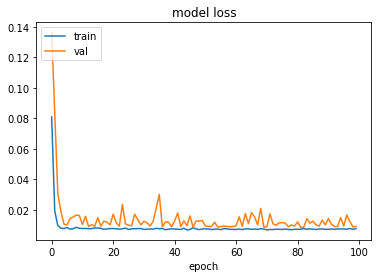

In [495]:
plt.plot(model_history.history['loss'])
plt.plot(model_history.history['val_loss']) 
plt.title('model loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(model_latih)
plt.show()

In [496]:
# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

In [497]:
# calculate  mean absolute error
trainScore = mean_absolute_error(trainY[0], trainPredict[:,0])
print('Train Score: %.2f MAE' % (trainScore))
testScore = mean_absolute_error(testY[0], testPredict[:,0])
print('Test Score: %.2f MAE' % (testScore))
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))
from sklearn.metrics import r2_score
r2TrainScore = r2_score(trainY[0], trainPredict[:,0])
print('Train R2 Score: %.2f R2 Score'% (r2TrainScore))
r2TestScore = r2_score(testY[0], testPredict[:,0])
print('Train R2 Score: %.2f R2 Score'% (r2TestScore))

Train Score: 86.10 MAE
Test Score: 119.15 MAE
Train Score: 115.15 RMSE
Test Score: 172.09 RMSE
Train R2 Score: 1.00 R2 Score
Train R2 Score: 0.98 R2 Score


In [498]:
# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

In [499]:
#Date For data
split = int(len(dataset)* 0.67)
all_date = dataframe.index
date_train = close.index[:split]
date_test = close.index[split:]

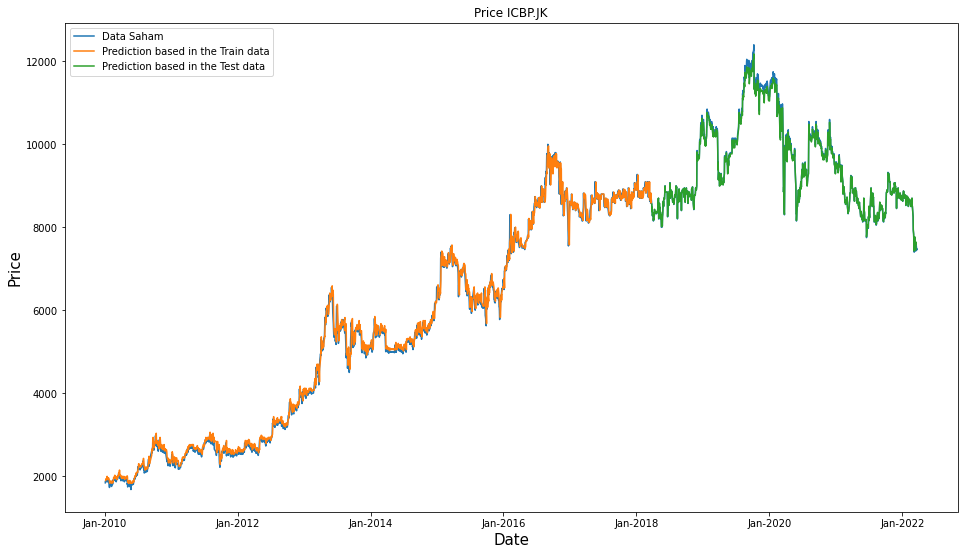

In [500]:
# plot baseline and predictions
fig, ax = plt.subplots(figsize=(16,9))
lb_saham = 'ICBP.JK'
ax.plot(all_date,scaler.inverse_transform(dataset), label = "Data Saham")
ax.plot(date_train[look_back+1:],trainPredict, label = "Prediction based in the Train data")
ax.plot(date_test[:-look_back-1],testPredict, label = "Prediction based in the Test data")
ax.set_title('Price {}'.format(lb_saham))

# Define the date format
date_form = DateFormatter("%b-%Y")
ax.xaxis.set_major_formatter(date_form)

ax.set_xlabel('Date',fontsize=15)
ax.set_ylabel('Price',fontsize=15)
ax.legend()
plt.savefig(model_latih+'plot')
plt.show()